In [23]:
# Open a new Colab notebook
# Copy and paste into the first cell, run it (▶️)

# Install CTGAN and dependencies
!pip install ctgan torch pandas numpy scikit-learn matplotlib seaborn pytorch-tabnet optuna

# Import libraries
import pandas as pd
import numpy as np
import torch
from ctgan import CTGAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetClassifier
import optuna

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Explanation:
# 1. '!pip install ctgan' adds the CTGAN library.
# 2. Other imports support data handling, modeling, and plotting.
# 3. Seeds ensure repeatability.
# 4. GPU check (enable via Runtime > Change runtime type > GPU).
# 5. Run this—takes ~1-2 minutes, outputs device (hopefully “cuda”).

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 49.4 MB/s eta 0:00:00
Using device: cuda


In [24]:
# Copy and paste into a new cell, run it
# Upload 'fetal_health.csv' first (left sidebar > drag-and-drop)

data = pd.read_csv('/content/fetal_health.csv')

# Top 10 features from SHAP (adjust if your list differs)
important_features = [
    'abnormal_short_term_variability', 'histogram_variance', 'mean_value_of_short_term_variability',
    'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mean', 'histogram_median',
    'histogram_mode', 'accelerations', 'uterine_contractions', 'prolongued_decelerations'
]
data_reduced = data[important_features + ['fetal_health']]

# Define X and y
X = data_reduced.drop('fetal_health', axis=1)
y = data_reduced['fetal_health'].astype(int)

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"X shape: {X_scaled.shape}")  # (2126, 10)
print(f"y distribution:\n{y.value_counts()}")

# Explanation:
# 1. Loads the dataset.
# 2. Selects 10 key features + target, reducing from 22 to 11 columns.
# 3. Splits into X (features) and y (target: 1, 2, 3).
# 4. Scales to [0, 1] for CTGAN compatibility.
# 5. Run this after uploading the CSV—check for (2126, 10) and class counts.

X shape: (2126, 10)
y distribution:
fetal_health
1    1655
2     295
3     176
Name: count, dtype: int64


In [28]:
# Replace your Part 3 cell with this, then rerun Parts 3-5

# Filter minority classes (Suspect: 2, Pathological: 3)
minority_classes = [2, 3]
minority_mask = y.isin(minority_classes)
X_minority = X_scaled[minority_mask]
y_minority = y[minority_mask]

# Combine features and target
data_minority = pd.concat([X_minority, y_minority.rename('fetal_health')], axis=1)

# Trim to a multiple of pac (default 10)
n_samples = len(data_minority)
pac = 10  # Default CTGAN pac value
n_samples_adjusted = (n_samples // pac) * pac  # 470 (drops 1 sample)
data_minority_trimmed = data_minority.iloc[:n_samples_adjusted]

print(f"Original minority samples: {n_samples}")
print(f"Adjusted minority samples: {n_samples_adjusted}")
print(f"Trimmed data shape: {data_minority_trimmed.shape}")

# Initialize CTGAN
# Setting batch_size to a multiple of pac
ctgan = CTGAN(epochs=500, batch_size=50, verbose=True) # Changed batch_size to 50, which is a multiple of pac (10)

# Train CTGAN
ctgan.fit(data_minority_trimmed, discrete_columns=['fetal_health'])

print("CTGAN training completed!")

# Explanation:
# 1. Filters minority data (471 samples initially).
# 2. Combines X and y into a DataFrame.
# 3. Trims to 470 samples (multiple of pac=10) to satisfy CTGAN’s requirement.
# 4. Trains CTGAN on the trimmed data, with batch_size adjusted to be a multiple of pac.
# 5. Run this—expect ~5-10 minutes, should complete without the AssertionError.

Original minority samples: 471
Adjusted minority samples: 470
Trimmed data shape: (470, 11)


Gen. (-0.20) | Discrim. (-1.53): 100%|██████████| 500/500 [01:47<00:00,  4.64it/s]

CTGAN training completed!


Gen. (-3.48) | Discrim. (-0.10): 100%|██████████| 500/500 [01:01<00:00,  8.18it/s]
Gen. (-0.67) | Discrim. (-1.56): 100%|██████████| 500/500 [00:37<00:00, 13.44it/s]


Synthetic data shape: (2839, 10)
GAN-augmented X shape: (4965, 10)
GAN-augmented y distribution:
fetal_health
2    1655
1    1655
3    1655
Name: count, dtype: int64


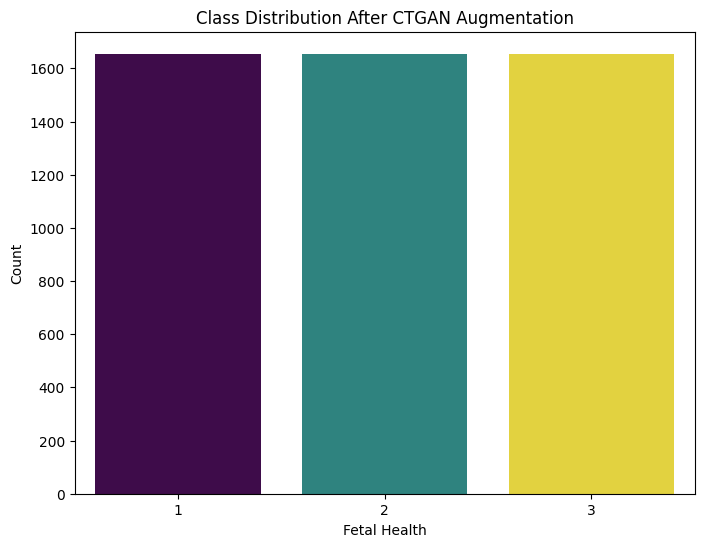

In [32]:
# Replace your Part 4 cell with this, run it after Part 3

# Number of synthetic samples to balance with Normal (1655)
n_suspect = 1655 - 295  # 1360
n_pathological = 1655 - 176  # 1479

# Split minority data by class
suspect_data = data_minority_trimmed[data_minority_trimmed['fetal_health'] == 2]  # 295 samples
pathological_data = data_minority_trimmed[data_minority_trimmed['fetal_health'] == 3]  # 175 samples

# Train CTGAN for Suspect
ctgan_suspect = CTGAN(epochs=500, batch_size=50, verbose=True)
ctgan_suspect.fit(suspect_data, discrete_columns=['fetal_health'])

# Train CTGAN for Pathological
ctgan_pathological = CTGAN(epochs=500, batch_size=50, verbose=True)
ctgan_pathological.fit(pathological_data, discrete_columns=['fetal_health'])

# Generate synthetic samples
synthetic_suspect = ctgan_suspect.sample(n_suspect)
synthetic_pathological = ctgan_pathological.sample(n_pathological)

# Combine synthetic data
synthetic_data = pd.concat([synthetic_suspect, synthetic_pathological], ignore_index=True)
synthetic_df = synthetic_data.drop('fetal_health', axis=1)
synthetic_labels = synthetic_data['fetal_health']

# Combine with original data
X_gan = pd.concat([X_scaled, synthetic_df], ignore_index=True)
y_gan = pd.concat([y, synthetic_labels], ignore_index=True)

print(f"Synthetic data shape: {synthetic_df.shape}")  # (2839, 10)
print(f"GAN-augmented X shape: {X_gan.shape}")      # (4965, 10)
print(f"GAN-augmented y distribution:\n{y_gan.value_counts()}")

plt.figure(figsize=(8, 6))
sns.countplot(x=y_gan, hue=y_gan, palette='viridis', legend=False)
plt.title('Class Distribution After CTGAN Augmentation')
plt.xlabel('Fetal Health')
plt.ylabel('Count')
plt.show()

# Explanation:
# 1. Splits the trimmed minority data (470 samples) into Suspect (295) and Pathological (175).
# 2. Trains separate CTGAN models for each class.
# 3. Generates exact numbers: 1360 Suspect, 1479 Pathological.
# 4. Combines synthetic samples (2839 total) with original data (4965 total).
# 5. Run this—takes ~10-20 minutes (two 500-epoch trainings), expect balanced classes (~1655 each).

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07677 | valid_accuracy: 0.60144 | test_accuracy: 0.61745 |  0:00:00s
epoch 1  | loss: 0.52814 | valid_accuracy: 0.57698 | test_accuracy: 0.56174 |  0:00:01s
epoch 2  | loss: 0.55608 | valid_accuracy: 0.44029 | test_accuracy: 0.44027 |  0:00:01s
epoch 3  | loss: 0.46382 | valid_accuracy: 0.49784 | test_accuracy: 0.49597 |  0:00:02s
epoch 4  | loss: 0.41953 | valid_accuracy: 0.51223 | test_accuracy: 0.4906  |  0:00:02s
epoch 5  | loss: 0.39829 | valid_accuracy: 0.51942 | test_accuracy: 0.53154 |  0:00:03s
epoch 6  | loss: 0.37841 | valid_accuracy: 0.59281 | test_accuracy: 0.58658 |  0:00:03s
epoch 7  | loss: 0.34966 | valid_accuracy: 0.61295 | test_accuracy: 0.62282 |  0:00:04s
epoch 8  | loss: 0.35162 | valid_accuracy: 0.64317 | test_accuracy: 0.6443  |  0:00:04s
epoch 9  | loss: 0.34594 | valid_accuracy: 0.62014 | test_accuracy: 0.62483 |  0:00:05s
epoch 10 | loss: 0.35527 | valid_accuracy: 0.64173 | test_accuracy: 0.65772 |  0:00:05s
epoch 11 | loss: 0.32048 | valid

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



CTGAN-Augmented TabNet Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.95      0.95       496
     Suspect       0.92      0.95      0.94       497
Pathological       0.98      0.94      0.96       497

    accuracy                           0.95      1490
   macro avg       0.95      0.95      0.95      1490
weighted avg       0.95      0.95      0.95      1490



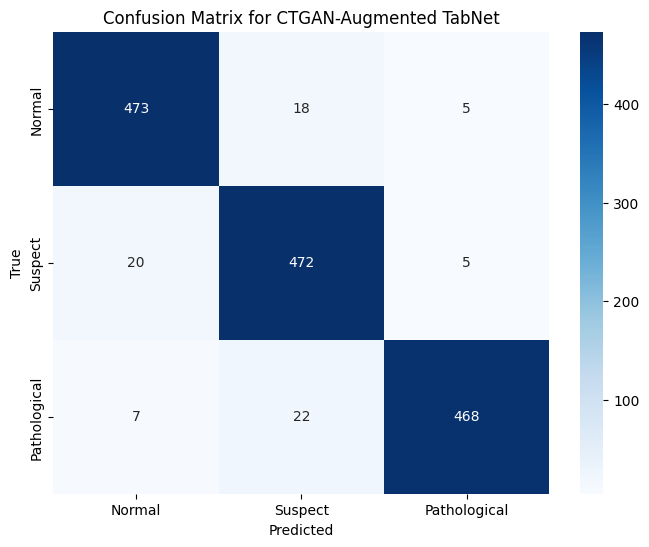

In [33]:
# Copy and paste into a new cell after Part 4, run it

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_gan, y_gan, test_size=0.3, random_state=42, stratify=y_gan)
X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Adjust y to {0, 1, 2}
y_train_final = y_train_final - 1
y_valid = y_valid - 1
y_test = y_test - 1

# Initialize TabNet with your best_params from part 2
# REPLACE THESE EXAMPLE VALUES WITH YOUR study.best_params FROM PART 2!
tabnet_gan = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5, gamma=1.5, lambda_sparse=0.001,
    optimizer_fn=torch.optim.Adam, optimizer_params={'lr': 0.02},
    mask_type='sparsemax', verbose=1, seed=42
)

# Train
tabnet_gan.fit(
    X_train_final.values, y_train_final.values,
    eval_set=[(X_valid.values, y_valid.values), (X_test.values, y_test.values)],
    eval_name=['valid', 'test'],
    eval_metric=['accuracy'],
    max_epochs=100,
    patience=20,
    batch_size=256,
    virtual_batch_size=128
)

# Evaluate
y_pred_gan = tabnet_gan.predict(X_test.values)
print("\nCTGAN-Augmented TabNet Classification Report:")
print(classification_report(y_test, y_pred_gan, target_names=['Normal', 'Suspect', 'Pathological']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_gan)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Suspect', 'Pathological'],
            yticklabels=['Normal', 'Suspect', 'Pathological'])
plt.title('Confusion Matrix for CTGAN-Augmented TabNet')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Explanation:
# 1. Splits data: 70% train (3475), 30% test (1490); train splits into ~2780 train, ~695 valid.
# 2. Adjusts y to 0-based indexing.
# 3. Uses placeholder TabNet params—YOU MUST REPLACE with your optimized values from part 2 (e.g., study.best_params).
# 4. Trains and evaluates (~5-10 minutes).
# 5. Run this—check if accuracy exceeds 96%.